# Imports, creating SparkSession, reading .csv file



In [152]:
pip install pyspark

In [153]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, sum, lit,regexp_replace, when, sqrt,log, log, exp, isnan, count, min, max, countDistinct, first, row_number, datediff, avg, round, upper, to_date, desc, round
from pyspark.sql.window import Window
from pyspark.sql.types import DateType, StringType, IntegerType, DoubleType, FloatType, NumericType, BooleanType
import matplotlib.pyplot as plt
from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import kagglehub
import numpy as np

In [154]:
# imports for geopandas
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
world = gpd.read_file("/content/ne_110m_admin_0_countries.shp")

In [155]:
spark = SparkSession.builder \
   .master("local") \
   .appName("survival_analysis") \
   .getOrCreate()

In [156]:
file_path = kagglehub.dataset_download("daniilmiheev/top-spotify-podcasts-daily-updated")
df= spark.read.format("csv").load(file_path, header=True, inferSchema=True, quote='"', escape = '"')
df.show()


+----------+----+------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------+--------------------+-----------+--------+---------+------------+----------------------+---------------+-------------+--------------------+---------------------+-------------------------+--------------+---------------+-------------------+---------+--------------------+
|      date|rank|region|chartRankMove|          episodeUri|             showUri|         episodeName|         description|           show.name|    show.description|      show.publisher|duration_ms|explicit|is_externally_hosted|is_playable|language|languages|release_date|release_date_precision|show.copyrights|show.explicit|           show.href|show.html_description|show.is_externally_hosted|show.languages|show.media_type|show.total_episodes|show.type|            show.uri|
+----------+----+------+-------------+----------

# Goal of survival analysis

The main goal of survival analysis in general is to mesaure - how much time passes before the event occurs? It is mostly used in the medical data to check, for how long observed patient will stay alive or will stay healthy.

In case of our dataset we would like to find the answers for 3 following questions:
1. How much time passes from release date of podcast episode to enter top200?
2. What is the probability that the podcast episode which entered to top200 will remain in that ranking for the 1st week, 2nd week and so on?
3. What are the factors that influence this survival probability, what causes podcast episode to remain in the ranking for a longer period of time?

To get answers to theses questions we need to perform some preprocessing of the data. At first, we delete all the columns that have only 1 unique values - they don't bring any new information to the data.

In [157]:
#changing column names because columns with . in the name raised the error
new_column_names = [col.replace('.', '_') for col in df.columns]
renamed_df = df.toDF(*new_column_names)
renamed_df.show()


+----------+----+------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------+--------------------+-----------+--------+---------+------------+----------------------+---------------+-------------+--------------------+---------------------+-------------------------+--------------+---------------+-------------------+---------+--------------------+
|      date|rank|region|chartRankMove|          episodeUri|             showUri|         episodeName|         description|           show_name|    show_description|      show_publisher|duration_ms|explicit|is_externally_hosted|is_playable|language|languages|release_date|release_date_precision|show_copyrights|show_explicit|           show_href|show_html_description|show_is_externally_hosted|show_languages|show_media_type|show_total_episodes|show_type|            show_uri|
+----------+----+------+-------------+----------

In [158]:
df = renamed_df

In [159]:
agg_expr = {col: countDistinct(col).alias(col + "_unique") for col in df.columns}
unique_counts = df.agg(*agg_expr.values()).collect()[0]
for col, unique_count in zip(df.columns, unique_counts):
      if(unique_count == 1):
        print(col, unique_count)

release_date_precision 1
show_copyrights 1
show_type 1


We identified 3 columns that have only 1 unique value - they can be dropped.

In [160]:
df = df.drop(*['release_date_precision', 'show_copyrights', 'show_type'])


Now, we will check the structure of the dataset - what are the types of the columns in the dataframe. Then we will take a look at the missing values and in case that we want to use those columns in survival analysis - how we are going to handle them.

In [161]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- episodeUri: string (nullable = true)
 |-- showUri: string (nullable = true)
 |-- episodeName: string (nullable = true)
 |-- description: string (nullable = true)
 |-- show_name: string (nullable = true)
 |-- show_description: string (nullable = true)
 |-- show_publisher: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- is_externally_hosted: boolean (nullable = true)
 |-- is_playable: boolean (nullable = true)
 |-- language: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_href: string (nullable = true)
 |-- show_html_description: string (nullable = true)
 |-- show_is_externally_hosted: boolean (nullable = true)
 |-- show_languages: string (nullabl

In [162]:
numerical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]
boolean_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, BooleanType)]
string_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
date_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, DateType)]


In [163]:
# for numerical columns
df.select([count(when(isnan(c)| df[c].isNull(), c )).alias(c) for c in numerical_columns]
   ).show()

+----+-----------+-------------------+
|rank|duration_ms|show_total_episodes|
+----+-----------+-------------------+
|   0|          0|                  0|
+----+-----------+-------------------+



Fortunately, all the numerical columns have no missing values. All of them will be used in the survival analysis (especially in the AFT model), so we are free to use them.

In [164]:
# for string columns
df.select([count(when(df[c].contains('None') | \
                            df[c].contains('NULL') | \
                            (df[c] == '' ) | \
                            df[c].isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in string_columns]).show()

+------+-------------+----------+-------+-----------+-----------+---------+----------------+--------------+--------+---------+---------+---------------------+--------------+---------------+--------+
|region|chartRankMove|episodeUri|showUri|episodeName|description|show_name|show_description|show_publisher|language|languages|show_href|show_html_description|show_languages|show_media_type|show_uri|
+------+-------------+----------+-------+-----------+-----------+---------+----------------+--------------+--------+---------+---------+---------------------+--------------+---------------+--------+
|     0|            0|         0|      0|          1|       2732|        0|              54|             0|       0|        0|        0|                   82|             0|              0|       0|
+------+-------------+----------+-------+-----------+-----------+---------+----------------+--------------+--------+---------+---------+---------------------+--------------+---------------+--------+



For some string columns we have missing values. However, for purpose of the survival analysis we would like to use columns:

region, chartRankMove, episodeUri, language, show_media_type

For all these columns there are no missing values, so we can proceed. The reason for choosing these columns is that they are connected with the specific podcast episode - not with the show itself. We are omitting description of the episode, because descriptions are long strings in different languages and it wouldn't be so easy to work with this column.  

In [165]:
# for dates
df.select(
    *[count(when(df[c].isNull() | (df[c] == '') | df[c].contains('None') | df[c].contains('NULL'), c)).alias(c)
      for c in date_columns]).show()

+----+------------+
|date|release_date|
+----+------------+
|   0|           0|
+----+------------+



All of date columns which are crucial for our analysis have no missing values.

In [166]:
# for booleans
df.select(
    *[count(when(df[c].isNull() | (df[c] == '') | df[c].contains('None') | df[c].contains('NULL'), c)).alias(c)
      for c in boolean_columns]).show()

+--------+--------------------+-----------+-------------+-------------------------+
|explicit|is_externally_hosted|is_playable|show_explicit|show_is_externally_hosted|
+--------+--------------------+-----------+-------------+-------------------------+
|       0|                   0|          0|            0|                        0|
+--------+--------------------+-----------+-------------+-------------------------+



All of the booleans columns have no missing values as well, which is good. However, booleans column that we are planning to use is:

explicit, is_externally_hosted, is_playable

The reason for that is we are going to make survival analysis for podcast episode and we would like to gather the most information about this specific episode, not about the whole show.

In [167]:
df_preprocessed = df.select('episodeUri', 'region', 'rank', 'chartRankMove', 'date', 'release_date', 'duration_ms', 'show_Total_episodes',  'language', 'show_media_type',  'explicit', 'is_externally_hosted', 'is_playable')

# How long does it take from release date to reach top100 in each region for episode?

Now we wil perform analysis on the first question that we would like to answer:

from podcast episode release date - how much time has to pass to reach top200?

To do that, we will use Window module to extract podcast episode within a region and then filter records to the first entries in the country - it is because some podcast episodes can 'go back' to the ranking in the later dates, but we are interested in the first success.

In [168]:
filtered_df = df_preprocessed.filter(df["chartRankMove"]=='NEW')

window_spec = Window.partitionBy("episodeUri", "region").orderBy("date")
ranked_df = filtered_df.withColumn("row_number", row_number().over(window_spec))
first_records_df = ranked_df.filter(ranked_df["row_number"] == 1).drop("row_number")
first_records_df.show()


+--------------------+------+----+-------------+----------+------------+-----------+-------------------+--------+---------------+--------+--------------------+-----------+
|          episodeUri|region|rank|chartRankMove|      date|release_date|duration_ms|show_Total_episodes|language|show_media_type|explicit|is_externally_hosted|is_playable|
+--------------------+------+----+-------------+----------+------------+-----------+-------------------+--------+---------------+--------+--------------------+-----------+
|001TNHD7zZmbMjtf7...|    jp|  78|          NEW|2024-10-02|  2024-10-01|     494961|               1556|   en-US|          audio|    true|               false|       true|
|001ddMpWj8X28okpf...|    jp| 169|          NEW|2024-10-14|  2024-10-13|    2363689|                152|      ja|          audio|   false|               false|       true|
|0020reOQCvPoIzdwL...|    es| 125|          NEW|2024-09-04|  2024-09-03|    1007438|                300|   es-ES|          audio|   false|  

Now we will count the number of days passed from release date to the first date that the episode reached that top200.

In [169]:
df = first_records_df
df_added = df.withColumn("top200_from_release", datediff(df["date"], df["release_date"]))
df_added.show()
df = df_added


+--------------------+------+----+-------------+----------+------------+-----------+-------------------+--------+---------------+--------+--------------------+-----------+-------------------+
|          episodeUri|region|rank|chartRankMove|      date|release_date|duration_ms|show_Total_episodes|language|show_media_type|explicit|is_externally_hosted|is_playable|top200_from_release|
+--------------------+------+----+-------------+----------+------------+-----------+-------------------+--------+---------------+--------+--------------------+-----------+-------------------+
|001TNHD7zZmbMjtf7...|    jp|  78|          NEW|2024-10-02|  2024-10-01|     494961|               1556|   en-US|          audio|    true|               false|       true|                  1|
|001ddMpWj8X28okpf...|    jp| 169|          NEW|2024-10-14|  2024-10-13|    2363689|                152|      ja|          audio|   false|               false|       true|                  1|
|0020reOQCvPoIzdwL...|    es| 125|      

After that we will count the average number of days for each region for the episode to reach top200 in that region.

In [170]:
avg_difference_by_region = df.groupBy("region").agg((round(avg("top200_from_release") / 0.5, 0) * 0.5).alias("avg_top200_from_release"))
df_upper = avg_difference_by_region.withColumn("region", upper(df["region"]))
df_upper.show()
average_value = df.select(avg("top200_from_release")).collect()[0][0]
print(average_value)

+------+-----------------------+
|region|avg_top200_from_release|
+------+-----------------------+
|    US|                    1.5|
|    CL|                   16.5|
|    JP|                    1.5|
|    PL|                    6.5|
|    IN|                   55.0|
|    AU|                    2.5|
|    GB|                    2.5|
|    CO|                   25.0|
|    DE|                    1.5|
|    BR|                    6.5|
|    ES|                    6.0|
|    IT|                    9.5|
|    AR|                   17.0|
|    PH|                   24.0|
|    NL|                    3.5|
|    CA|                    2.5|
|    NZ|                    2.5|
|    AT|                    1.5|
|    MX|                   12.0|
|    FR|                    7.0|
+------+-----------------------+
only showing top 20 rows

8.141002259842207


# Geopandas visualization

In order to visualize the result we need to convert our PySpark dataframe to the pandas one.

In [171]:
df_pandas = df_upper.toPandas()

In [172]:
world_without_antarctica = world[world['NAME'] != 'Antarctica']
world = world_without_antarctica

In [173]:
world = world.merge(df_pandas, how='left', left_on='ISO_A2', right_on='region')

In [174]:
original_cmap = plt.cm.Oranges
new_cmap = mcolors.ListedColormap([original_cmap(i) for i in range(40,200)])

<Axes: title={'center': 'The number of days for podcast episode to reach top 200 from its release date'}>

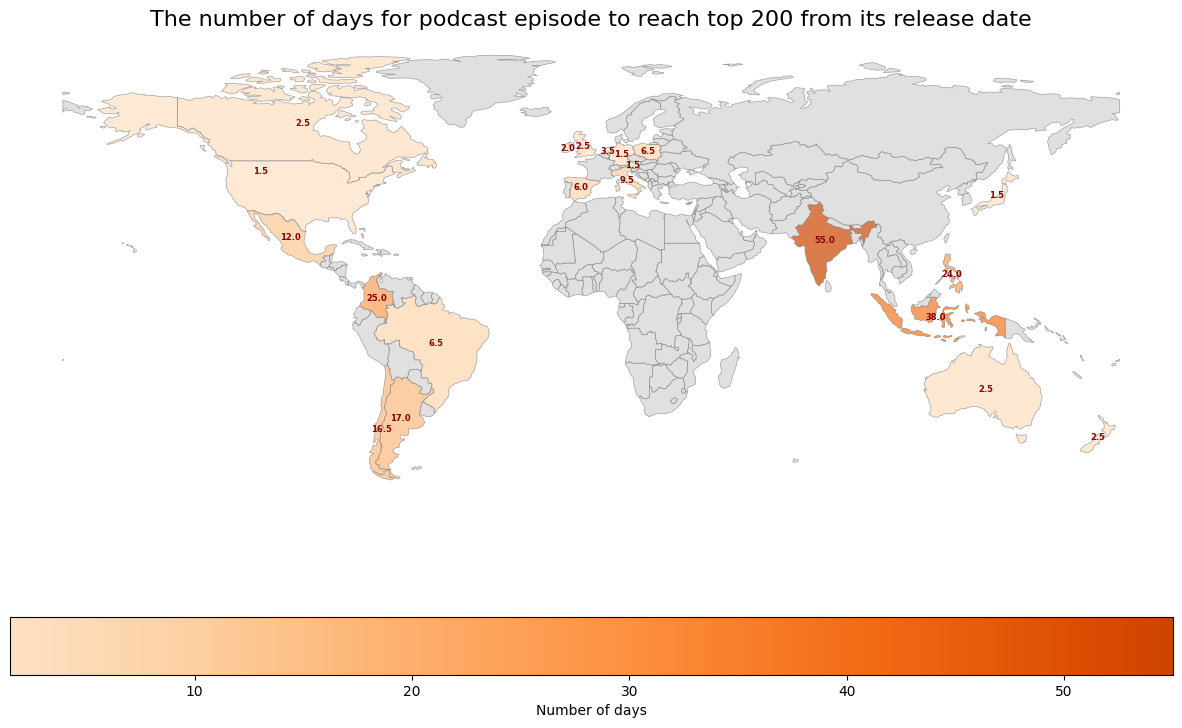

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for idx, row in world.iterrows():
    if pd.notnull(row['avg_top200_from_release']):
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
        ax.text(x, y, str(row['avg_top200_from_release']), fontsize=6, color='darkred', ha='center', va='center', fontweight='bold')
ax.set_title('The number of days for podcast episode to reach top 200 from its release date', fontsize=16)
ax.axis('off')
world.plot(
    column='avg_top200_from_release',
    cmap= new_cmap,
    legend=True,
    linewidth=0.5,
    legend_kwds={'label': "Number of days", 'orientation': "horizontal"},
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    edgecolor ='grey',
    alpha=0.7,
    ax=ax
)


# Data preparation for Kaplan-Maier Curve

---




A Kaplan-Meier curve is a statistical tool used to estimate the survival function from time-to-event data. It is commonly used in medical research and survival analysis to visualize the probability of survival over time.

In case of our dataset we would like to know what is the survival probability for a podcast episode to remain in the following week - 1st, 2nd and so on.

To prepare data for creating a Kaplan Meier curve two basic columns are needed: the time column and the event column:


*   time column indicates the time that has passed from starting observing the record and to the moment of occurence of event
*   event column indicates wheter event occured or not - 1 if it occurred and 0 for absence of event.

In our research as time column we will consider the number of days that the podcast episode was staying in the top200 of certain region. As an event column we will define whether the episode dropped out of top200 under observed period- if yes, the value will equal to 1, and 0 for the opposite.



In [176]:
sorted_df = df_preprocessed.orderBy("date", ascending=True)
last_date = sorted_df.tail(1)[0]["date"]
print(last_date)

2024-10-24


In [177]:
df_modified = df_preprocessed.withColumn(
    "censored",
    when(df_preprocessed["date"] == last_date, 1).otherwise(0))

In [178]:
df_modified = df_modified.withColumn(
    "event",
    when(df_modified["censored"] == 1, 0).otherwise(1))

Now we would like to compute the time in ranking for each podcast episode - how long did the podcast remain nonstop in the chart since entering it. Then we will compute the average time in ranking for the whole data and later on - within the regions.

In [179]:
window_spec = Window.partitionBy("episodeUri", "region")
df_with_dates = df_modified.withColumn("first_date", min("date").over(window_spec)) \
                  .withColumn("last_date", max("date").over(window_spec))
df_with_time = df_with_dates.withColumn("time_in_ranking", (datediff(df_with_dates["last_date"], df_with_dates["first_date"])+1))
episode_region_combinations = df_with_time.select("episodeUri", "region").distinct()
df_joined = df_with_time.join(episode_region_combinations, on=["episodeUri", "region"], how="inner")
survival_analysis_data = df_joined.dropDuplicates(["episodeUri", "region"])

average_value = survival_analysis_data.select(avg("time_in_ranking")).collect()[0][0]
print("Average number of days for a podcast episode to remain in ranking is: ")
print(average_value)
average_values_df = survival_analysis_data.groupBy("region").agg(round(avg("time_in_ranking"),2).alias("average_time_in_ranking"))
average_values_df.show()

Average number of days for a podcast episode to remain in ranking is: 
4.007834160809852
+------+-----------------------+
|region|average_time_in_ranking|
+------+-----------------------+
|    us|                   2.91|
|    cl|                   4.86|
|    jp|                   3.98|
|    pl|                   5.72|
|    in|                   8.13|
|    au|                   3.17|
|    gb|                    3.3|
|    co|                    5.6|
|    de|                   3.53|
|    br|                    3.6|
|    es|                   3.29|
|    it|                   3.55|
|    ar|                   4.77|
|    ph|                   6.18|
|    nl|                   3.74|
|    ca|                   3.11|
|    nz|                   3.08|
|    at|                   3.75|
|    mx|                   4.34|
|    fr|                   3.09|
+------+-----------------------+
only showing top 20 rows



Now, the proper Kaplan Meier dataframe preparation starts. We narrow down our dataset only to these podcast episodes, that entered the ranking at the beginning of observed period which is 02.09.2024 - so their first_date in ranking has to be like that and also their chartRankMove has to be NEW.

We do that in order to make the results more reliable and interpretable - otherwise we would take into consideration episodes that were at 'the end' of their time in chart.

In [180]:
filtered_df = df_joined.filter((df_joined['first_date']=='2024-09-02') & (df_joined['chartRankMove']=='NEW'))
distinct_episodes_df = filtered_df.dropDuplicates(["episodeUri", "region"])
df_Kaplan = distinct_episodes_df.select(*['episodeUri', 'region','time_in_ranking', 'event', 'first_date', 'last_date'])
print(df_Kaplan.count())
df_Kaplan.show()

740
+--------------------+------+---------------+-----+----------+----------+
|          episodeUri|region|time_in_ranking|event|first_date| last_date|
+--------------------+------+---------------+-----+----------+----------+
|00gWKlCF85pxfPoVm...|    fr|              2|    1|2024-09-02|2024-09-03|
|03QcjM7P4mdW7bbsJ...|    ph|              3|    1|2024-09-02|2024-09-04|
|03oJYhzSTjLKHdYte...|    ar|              1|    1|2024-09-02|2024-09-02|
|04wzuAwQhpuUZnrEP...|    cl|             10|    1|2024-09-02|2024-09-11|
|04x9N3cnhbfeLwnxV...|    co|             53|    1|2024-09-02|2024-10-24|
|06tEdaKqVaui7g2g6...|    mx|             19|    1|2024-09-02|2024-09-20|
|07wZdWaZ2wl8gY2FH...|    pl|              1|    1|2024-09-02|2024-09-02|
|08YvbR19U7Qvc1McI...|    gb|              2|    1|2024-09-02|2024-09-03|
|09IJVMMGVAukAySkc...|    in|             20|    1|2024-09-02|2024-09-21|
|09QmVmqkgYciFGMDu...|    au|              2|    1|2024-09-02|2024-09-03|
|0AzgFs8yyndibuZ7Z...|    gb|     

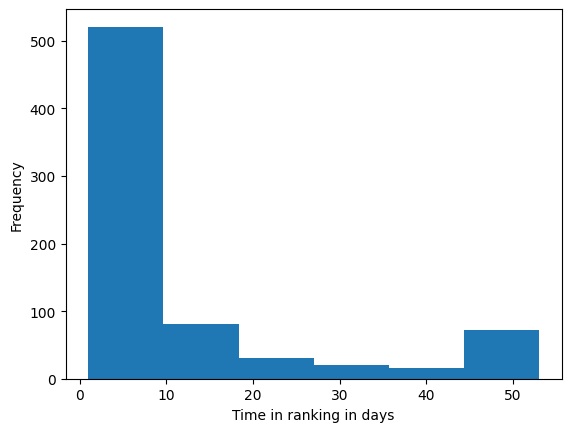

In [181]:
df = df_Kaplan.toPandas()
T = df["time_in_ranking"]
E = df["event"]
plt.hist(T, bins = 6)
plt.xlabel("Time in ranking in days")
plt.ylabel("Frequency")
plt.show()

As we can see at the plot above the distribution of the time in ranking for podcast episodes looks like gamma distribution with low shape parameter - the most of the podcast episodes drop out of the ranking under 10 days of their 'life' in it.

## Preparing the life table

Now we will prepare a life table or actuarial table in order to estimate life expectancy. A life table in survival analysis is a statistical tool used to summarize the survival patterns of a population over time. It provides a structured way to estimate the probability of survival and related metrics at different time intervals. In case of our dataset it estimates the expected number of days that podcast's epsiode will remain in the top200 in the following weeks.

In [182]:
max_last_date = df_Kaplan.agg(max(df_Kaplan["last_date"]).alias("max_last_date"))
max_last_date.show()

+-------------+
|max_last_date|
+-------------+
|   2024-10-24|
+-------------+



The maximum date that podcast episode from the beginning remained in the top200 is 24.10.2024 and therefore we will conduct the survival analysis for time period of 8 weeks. The life table will have a following structure:
1. $t$ - *interval in weeks* - (0,1] weeks, (1,2] weeks, (2,3] weeks, (3,4], (4,5], (5,6], (6,7], (7,8] weeks
2. $N_t$  - *number at risk for interval* - this is the number of episodes that remaind 'alive' at the beginning of the interval
3. $D_t$ - *number of deaths during interval* - this is the number of podcast episode which simply dropped out of top200 in the specific interval
4. $q_t$ - *proportion dying during interval* - which is simply $D_t/N_t$
5. $p_t$ - *proportion surviving interval* - which is simply $1-q_t$
6. $S_t$ - *cumulative survival probability* - represent the proportion of episodes remaining 'alive' over time intervals, in general $S_{t+1} =S_t\cdot p_{t+1}$

In [183]:
week_1 = '2024-09-08'
week_2 = '2024-09-15'
week_3 = '2024-09-22'
week_4 = '2024-09-29'
week_5 = '2024-10-06'
week_6 = '2024-10-13'
week_7 = '2024-10-20'
week_8 = '2024-10-27'
weeks = [week_1, week_2, week_3, week_4, week_5, week_6, week_7, week_8]
df_life_table = df_Kaplan.withColumn('died_week_1', when(df_Kaplan['last_date']<=week_1, 1).otherwise(0))
for i in range(1, len(weeks)):
    week_column = f"died_week_{i + 1}"
    df_life_table = df_life_table.withColumn(
        week_column,
        when(
            (df_Kaplan["last_date"] <= weeks[i]) & (df_Kaplan["last_date"] > weeks[i - 1]),
            1
        ).otherwise(0)
    )
df_life_table = df_life_table.withColumn("interval_1", lit(1))
for i in range(1, len(weeks)):
    interval_col = f"interval_{i + 1}"
    df_life_table = df_life_table.withColumn(
        interval_col,
        when(df_Kaplan["last_date"] > weeks[i - 1], 1).otherwise(0)
    )
df_life_table.show()

+--------------------+------+---------------+-----+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|          episodeUri|region|time_in_ranking|event|first_date| last_date|died_week_1|died_week_2|died_week_3|died_week_4|died_week_5|died_week_6|died_week_7|died_week_8|interval_1|interval_2|interval_3|interval_4|interval_5|interval_6|interval_7|interval_8|
+--------------------+------+---------------+-----+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|00gWKlCF85pxfPoVm...|    fr|              2|    1|2024-09-02|2024-09-03|          1|          0|          0|          0|          0|          0|          0|          0|         1|         0|         0|         0|         0|  

Now we will create a proper life table in dataframe.

In [184]:
interval_columns = [f"interval_{i}" for i in range(1, 9)]
died_columns = [f"died_week_{i}" for i in range(1, 9)]
number_of_alive = [sum((col)).alias(col) for col in interval_columns]
number_of_deaths = [sum(col).alias(col) for col in died_columns]
alive_df = df_life_table.select(number_of_alive).collect()[0]
death_df = df_life_table.select(number_of_deaths).collect()[0]

In [185]:
interval_data = []
for i in range(7):
    interval_data.append(
        (f"{i+1}", alive_df[i], death_df[i])
    )
life_table = spark.createDataFrame(interval_data, ["week", "N_t", "D_t"])
life_table = life_table.withColumn("q_t", round(life_table["D_t"] / life_table["N_t"],2))
life_table = life_table.withColumn("p_t", round(1-life_table["q_t"],2))


In [186]:
life_table = life_table.withColumn("S_t", lit(1.0))
first_row = life_table.first().asDict()
first_row["S_t"] = first_row["p_t"]
updated_first_row = Row(**first_row)
remaining_rows = life_table.collect()[1:]
updated_rows= [updated_first_row] + remaining_rows
life_table = spark.createDataFrame(updated_rows)


In [187]:
def calculate_survival_probability(life_table):
    window_spec = Window.orderBy(life_table.columns[0]).rowsBetween(Window.unboundedPreceding, Window.currentRow)

    life_table = life_table.withColumn("log_p_t", log(life_table["p_t"]))

    life_table = life_table.withColumn("cum_log_p_t", sum("log_p_t").over(window_spec))

    life_table = life_table.withColumn("S_t", exp(life_table["cum_log_p_t"]))
    life_table = life_table.withColumn("S_t", round(life_table["S_t"], 2)) \
                          .drop("log_p_t", "cum_log_p_t")

    return life_table


In [188]:
life_table = calculate_survival_probability(life_table)

In [189]:
life_table.show()

+----+---+---+----+----+----+
|week|N_t|D_t| q_t| p_t| S_t|
+----+---+---+----+----+----+
|   1|740|452|0.61|0.39|0.39|
|   2|288|119|0.41|0.59|0.23|
|   3|169| 47|0.28|0.72|0.17|
|   4|122| 17|0.14|0.86|0.14|
|   5|105| 17|0.16|0.84|0.12|
|   6| 88| 10|0.11|0.89|0.11|
|   7| 78| 18|0.23|0.77|0.08|
+----+---+---+----+----+----+



Now, the life table is ready. We have the attributes:

*   $N_t$ which tells us about the number of episodes that remained in top200
*   $D_t$ which is the number of podcast that dropped out of the top200 in this specific week
*   $q_t$ which is simply proportion of "dying" in the week $t$
*   $p_t$ which is the proportion of "surviving" in the week $t$

As we can see the biggest proportion of "dying" is in the week 1 - it is very probable that the podcast episode will drop out of the ranking in the first week of its lifetime. With passing the time this proportion decrease drastically, so it means that episodes that survived this first week of their popularity will likely remain in the ranking.





## Creating Kaplan - Meier curve

The life table approach estimates survival probabilities over fixed intervals, but results can vary depending on interval organization, especially in small samples. The Kaplan-Meier method (product-limit approach) addresses this by recalculating survival probabilities at each event time, allowing for more precise estimates.

The table below applies the Kaplan-Meier approach to the same data as before. At Time=0, the survival probability is 1 (100%), as all participants are at risk. The Kaplan-Meier formula, $$S_{t+1} = S_t \cdot \frac{(N_{t+1}-D_{t+1})}{N_{t+1}} $$
 differs from the life table approach by using event instead of fixed intervals, as detailed in the first rows of the table.

In [190]:
#for life table in Kaplan-Meier Approach we can drop columns p_t, q_t and just leave N_t, D_t, week, S_t
Kaplan_life_table = life_table.drop(*['q_t', 'p_t'])
schema_Kaplan = Kaplan_life_table.schema
Kaplan_life_table_first_row = Kaplan_life_table.first().asDict()
Kaplan_life_table_first_row["week"] = 0
Kaplan_life_table_first_row["S_t"] = 1.0
new_row = Row(**Kaplan_life_table_first_row)
new_df = spark.createDataFrame([new_row])
Kaplan_life_table = new_df.union(Kaplan_life_table)
Kaplan_life_table.show()

+----+---+---+----+
|week|N_t|D_t| S_t|
+----+---+---+----+
|   0|740|452| 1.0|
|   1|740|452|0.39|
|   2|288|119|0.23|
|   3|169| 47|0.17|
|   4|122| 17|0.14|
|   5|105| 17|0.12|
|   6| 88| 10|0.11|
|   7| 78| 18|0.08|
+----+---+---+----+



In [191]:
#quickly switch to Pandas because Pyspark doesn't support inductive calculations
Kaplan_pd =Kaplan_life_table.toPandas()
for i in range(1, len(Kaplan_pd)):
    Kaplan_pd.loc[i, 'S_t_dynamic'] = Kaplan_pd.loc[i-1, 'S_t'] * ((Kaplan_pd.loc[i, 'N_t'] - Kaplan_pd.loc[i, 'D_t']) / Kaplan_pd.loc[i, 'N_t'])
Kaplan_life_table = spark.createDataFrame(Kaplan_pd)
Kaplan_life_table.show()


+----+---+---+----+-------------------+
|week|N_t|D_t| S_t|        S_t_dynamic|
+----+---+---+----+-------------------+
|   0|740|452| 1.0|                NaN|
|   1|740|452|0.39| 0.3891891891891892|
|   2|288|119|0.23| 0.2288541666666667|
|   3|169| 47|0.17|0.16603550295857988|
|   4|122| 17|0.14|0.14631147540983608|
|   5|105| 17|0.12|0.11733333333333335|
|   6| 88| 10|0.11|0.10636363636363635|
|   7| 78| 18|0.08|0.08461538461538462|
+----+---+---+----+-------------------+



In [192]:
schema_Kaplan = Kaplan_life_table.schema
df_columns = ["week", "N_t", "S_t", "S_t_dynamic"]
Kaplan_life_table = Kaplan_life_table.rdd.zipWithIndex().filter(lambda x: x[1] != 0).map(lambda x: x[0]).toDF(df_columns)


In [193]:
new_row = spark.createDataFrame([(0, 740, 452, 1.0, 1.0)], schema = schema_Kaplan )
Kaplan_life_table = new_row.union(Kaplan_life_table)
Kaplan_life_table = Kaplan_life_table.select(['week', 'N_t', 'D_t', 'S_t_dynamic'])
Kaplan_life_table.show()

+----+---+---+-------------------+
|week|N_t|D_t|        S_t_dynamic|
+----+---+---+-------------------+
|   0|740|452|                1.0|
|   1|740|452| 0.3891891891891892|
|   2|288|119| 0.2288541666666667|
|   3|169| 47|0.16603550295857988|
|   4|122| 17|0.14631147540983608|
|   5|105| 17|0.11733333333333335|
|   6| 88| 10|0.10636363636363635|
|   7| 78| 18|0.08461538461538462|
+----+---+---+-------------------+



In [194]:
Kaplan_life_table = Kaplan_life_table.withColumn("S_t_dynamic", round(Kaplan_life_table["S_t_dynamic"], 2))
Kaplan_life_table.show()

+----+---+---+-----------+
|week|N_t|D_t|S_t_dynamic|
+----+---+---+-----------+
|   0|740|452|        1.0|
|   1|740|452|       0.39|
|   2|288|119|       0.23|
|   3|169| 47|       0.17|
|   4|122| 17|       0.15|
|   5|105| 17|       0.12|
|   6| 88| 10|       0.11|
|   7| 78| 18|       0.08|
+----+---+---+-----------+



This is the final life table for Kaplan - Meier approach, which is suitable to draw a Kaplan - Meier curve.

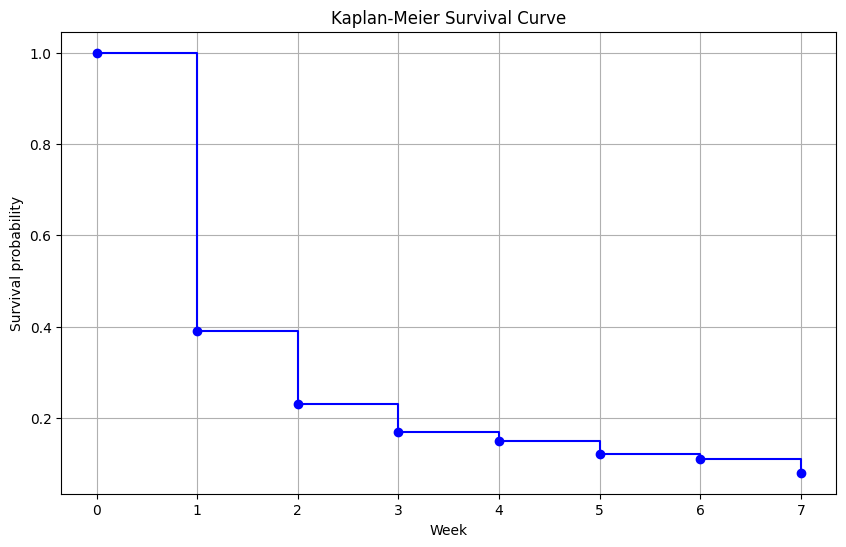

In [195]:
Kaplan_df = Kaplan_life_table.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(Kaplan_df['week'], Kaplan_df['S_t_dynamic'], drawstyle='steps-post', marker='o', linestyle='-', color='b')
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Week')
plt.ylabel('Survival probability')
plt.grid(True)
plt.show()

Now, in order to add confidence intervals to this curve, we have to extend our Kaplan Meier life table and add standard errors for these survival estimates.
We use Greenwoods formula for these calculations


In [196]:
Kaplan_SE = Kaplan_life_table.withColumn('quotient', Kaplan_life_table['D_t']/(Kaplan_life_table['N_t']*(Kaplan_life_table['N_t']-Kaplan_life_table['D_t'])))
Kaplan_SE.show()

+----+---+---+-----------+--------------------+
|week|N_t|D_t|S_t_dynamic|            quotient|
+----+---+---+-----------+--------------------+
|   0|740|452|        1.0|0.002120870870870871|
|   1|740|452|       0.39|0.002120870870870871|
|   2|288|119|       0.23|0.002444937541091...|
|   3|169| 47|       0.17|0.002279561548161...|
|   4|122| 17|       0.15|0.001327088212334114|
|   5|105| 17|       0.12| 0.00183982683982684|
|   6| 88| 10|       0.11|0.001456876456876457|
|   7| 78| 18|       0.08|0.003846153846153...|
+----+---+---+-----------+--------------------+



In [197]:
window_spec = Window.orderBy("week").rowsBetween(Window.unboundedPreceding, Window.currentRow)
Kaplan_SE = Kaplan_SE.withColumn("quotient_cum", sum(Kaplan_SE["quotient"]).over(window_spec))
Kaplan_SE = Kaplan_SE.withColumn("quotient_cum_root", Kaplan_SE["S_t_dynamic"]*sqrt(Kaplan_SE["quotient_cum"]))
Kaplan_SE = Kaplan_SE.withColumn("confidence_interval", 1.96*Kaplan_SE["quotient_cum_root"])
Kaplan_SE = Kaplan_SE.withColumn("confidence_upper", Kaplan_SE["S_t_dynamic"]+Kaplan_SE["confidence_interval"])
Kaplan_SE = Kaplan_SE.withColumn("confidence_lower", Kaplan_SE["S_t_dynamic"]-Kaplan_SE["confidence_interval"])
Kaplan_SE.show()

+----+---+---+-----------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+
|week|N_t|D_t|S_t_dynamic|            quotient|        quotient_cum|   quotient_cum_root| confidence_interval|   confidence_upper|   confidence_lower|
+----+---+---+-----------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+
|   0|740|452|        1.0|0.002120870870870871|0.002120870870870871| 0.04605291381520686| 0.09026371107780545| 1.0902637110778055| 0.9097362889221945|
|   1|740|452|       0.39|0.002120870870870871|0.004241741741741742| 0.02540017556866328| 0.04978434411458003|0.43978434411458006|0.34021565588541997|
|   2|288|119|       0.23|0.002444937541091...|0.006686679282833129|0.018807587140882067| 0.03686287079612885|0.26686287079612886|0.19313712920387116|
|   3|169| 47|       0.17|0.002279561548161...| 0.00896624083099493|0.016097340153446268| 0.03

In [198]:
Kaplan_SE_pd = Kaplan_SE.toPandas()
def create_stepwise_data(x, y):
    x_steps = np.repeat(x, 2)[1:]
    y_steps = np.repeat(y, 2)[:-1]
    return x_steps, y_steps
x_steps, y_steps = create_stepwise_data(Kaplan_SE_pd["week"], Kaplan_SE_pd["S_t_dynamic"])
_, lower_steps = create_stepwise_data(Kaplan_SE_pd["week"], Kaplan_SE_pd["confidence_lower"])
_, upper_steps = create_stepwise_data(Kaplan_SE_pd["week"], Kaplan_SE_pd["confidence_upper"])

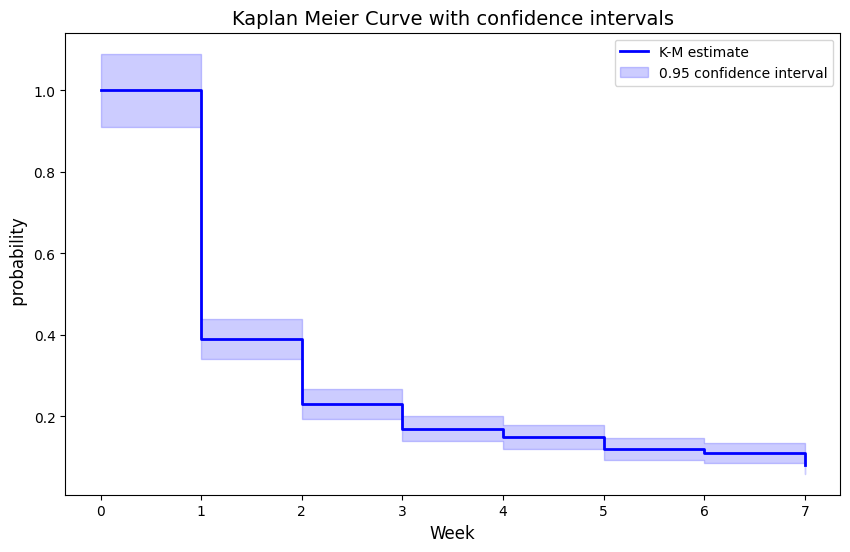

In [199]:
plt.figure(figsize=(10, 6))

plt.plot(Kaplan_SE_pd["week"], Kaplan_SE_pd["S_t_dynamic"], drawstyle='steps-post', label="K-M estimate", color="blue", linewidth=2)
plt.fill_between(
    x_steps,
    lower_steps,
    upper_steps,
    color="blue",
    alpha=0.2,
    label="0.95 confidence interval",
)

# Add labels, title, and legend
plt.xlabel("Week", fontsize=12)
plt.ylabel(" probability", fontsize=12)
plt.title("Kaplan Meier Curve with confidence intervals", fontsize=14)
plt.legend()

# Accelerated Failure Time Model

The Accelerated Failure Time (AFT) model is a survival analysis technique used to predict the time until an event occurs. Unlike proportional hazards models, which focus on the hazard ratio, the AFT model directly models the logarithm of survival time as a linear function of covariates. The model assumes that explanatory variables accelerate or decelerate the survival time multiplicatively.


In [200]:
AFT_data = survival_analysis_data.select(*['episodeUri', 'region', 'time_in_ranking', 'event', 'rank', 'language', 'censored', 'show_total_episodes', 'duration_ms', 'explicit', 'is_playable', 'is_externally_hosted', 'show_media_type'])
AFT_data = AFT_data.withColumn("explicit", when(AFT_data["explicit"]==True, 1).otherwise(0))
AFT_data = AFT_data.withColumn("is_playable", when(AFT_data["is_playable"]==True, 1).otherwise(0))
AFT_data = AFT_data.withColumn("is_externally_hosted", when(AFT_data["is_externally_hosted"]==True, 1).otherwise(0))
#for show_media_type for value 'audio' we will use 1
AFT_data = AFT_data.withColumn("show_media_type", when(AFT_data["show_media_type"]=='audio', 1).otherwise(0))
AFT_data = AFT_data.withColumn("language_cleaned",regexp_replace(AFT_data['language'], "-.*", "") )
#AFT_data.show()

In [201]:
indexer = StringIndexer(inputCol="language_cleaned", outputCol="language_index")
encoder = OneHotEncoder(inputCol="language_index", outputCol="language_vec")
pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(AFT_data)
encoded_data = model.transform(AFT_data)
encoded_data.show()

+--------------------+------+---------------+-----+----+--------+--------+-------------------+-----------+--------+-----------+--------------------+---------------+----------------+--------------+--------------+
|          episodeUri|region|time_in_ranking|event|rank|language|censored|show_total_episodes|duration_ms|explicit|is_playable|is_externally_hosted|show_media_type|language_cleaned|language_index|  language_vec|
+--------------------+------+---------------+-----+----+--------+--------+-------------------+-----------+--------+-----------+--------------------+---------------+----------------+--------------+--------------+
|001TNHD7zZmbMjtf7...|    jp|              3|    1|  78|   en-US|       0|               1556|     494961|       1|          1|                   0|              1|              en|           0.0|(27,[0],[1.0])|
|001ddMpWj8X28okpf...|    jp|              3|    1| 169|      ja|       0|                152|    2363689|       0|          1|                   0|    

In [202]:
data = encoded_data

In [203]:
indexer = StringIndexer(inputCol="region", outputCol="region_index")
encoder = OneHotEncoder(inputCol="region_index", outputCol="region_vec")
pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(data)
encoded_data = model.transform(data)
encoded_data.show()

+--------------------+------+---------------+-----+----+--------+--------+-------------------+-----------+--------+-----------+--------------------+---------------+----------------+--------------+--------------+------------+---------------+
|          episodeUri|region|time_in_ranking|event|rank|language|censored|show_total_episodes|duration_ms|explicit|is_playable|is_externally_hosted|show_media_type|language_cleaned|language_index|  language_vec|region_index|     region_vec|
+--------------------+------+---------------+-----+----+--------+--------+-------------------+-----------+--------+-----------+--------------------+---------------+----------------+--------------+--------------+------------+---------------+
|001TNHD7zZmbMjtf7...|    jp|              3|    1|  78|   en-US|       0|               1556|     494961|       1|          1|                   0|              1|              en|           0.0|(27,[0],[1.0])|        13.0|(21,[13],[1.0])|
|001ddMpWj8X28okpf...|    jp|       

In [204]:
AFT_features = encoded_data.select(*['time_in_ranking', 'event', 'rank', 'show_total_episodes', 'duration_ms', 'explicit','is_playable', 'is_externally_hosted', 'show_media_type', 'language_vec', 'region_vec'])
AFT_features.show()
columns = AFT_features.columns
del columns[0]
del columns[0]
assembler = VectorAssembler(inputCols=columns, outputCol="assembledfeatures")
AFT_features = assembler.transform(AFT_features)
AFT_model_data = AFT_features.select(*['time_in_ranking', 'event', 'assembledfeatures'])
AFT_model_data.show()

+---------------+-----+----+-------------------+-----------+--------+-----------+--------------------+---------------+--------------+---------------+
|time_in_ranking|event|rank|show_total_episodes|duration_ms|explicit|is_playable|is_externally_hosted|show_media_type|  language_vec|     region_vec|
+---------------+-----+----+-------------------+-----------+--------+-----------+--------------------+---------------+--------------+---------------+
|              3|    1|  78|               1556|     494961|       1|          1|                   0|              1|(27,[0],[1.0])|(21,[13],[1.0])|
|              3|    1| 169|                152|    2363689|       0|          1|                   0|              1|(27,[7],[1.0])|(21,[13],[1.0])|
|              1|    1| 125|                300|    1007438|       0|          1|                   0|              1|(27,[1],[1.0])| (21,[5],[1.0])|
|              5|    1|   4|               1466|    2021250|       0|          1|                   

In [205]:
aft = AFTSurvivalRegression(
    quantileProbabilities=[0.3, 0.6],
    quantilesCol="quantiles",
    featuresCol = 'assembledfeatures',
    labelCol='time_in_ranking',
    censorCol='event'
)
model = aft.fit(AFT_model_data)
predictions = model.transform(AFT_model_data)
predictions.show()


+---------------+-----+--------------------+------------------+--------------------+
|time_in_ranking|event|   assembledfeatures|        prediction|           quantiles|
+---------------+-----+--------------------+------------------+--------------------+
|              3|    1|(55,[0,1,2,3,4,6,...|3.1590108904162024|[1.30526908072493...|
|              3|    1|(55,[0,1,2,4,6,14...| 3.670463355434935|[1.51659569908982...|
|              1|    1|(55,[0,1,2,4,6,8,...|2.7047366421211816|[1.11756788214156...|
|              5|    1|(55,[0,1,2,4,11,4...| 4.688388284883485|[1.93719125352086...|
|              1|    1|(55,[0,1,2,4,6,7,...|1.5407780271238523|[0.63663279071512...|
|              2|    1|(55,[0,1,2,3,4,6,...|2.5462344805661163|[1.05207650592201...|
|              2|    1|(55,[0,1,2,3,4,6,...|3.1838120069619134|[1.31551663342973...|
|              1|    1|(55,[0,1,2,4,6,7,...| 2.606641348439227|[1.07703596938490...|
|              2|    1|(55,[0,1,2,4,6,15...| 5.414355876900505|[2

In [206]:
print("Coefficients: " + str(model.coefficients))
print(len(model.coefficients))
print("Intercept: " + str(model.intercept))
print("Scale: " + str(model.scale))

Coefficients: [-0.005227821454609564,-0.00029855636459705215,6.599901366224987e-08,0.06355994172882197,0.41792170367366943,-0.5431662485134019,-0.06508048832938754,-2.0847518014317914,-2.042060896759582,-1.9477650896916063,-2.1008273071511177,-1.9755016039497104,-1.9980830595908081,-2.244651086243929,-1.937908508286089,-1.5229944695898283,-1.574681125032227,-1.0103894896793792,-1.8879284944436157,-2.3471172796603996,-1.693887199358385,-1.5754303190699153,-2.0552593314217837,-2.3344846284296414,-0.6502138199100389,0.19558570149712595,-2.706711608571536,0.20630594019470333,-3.0966090702548037,-2.298849301717377,-2.1033474695670087,-0.09330360785795662,-3.476553643954968,-2.9205412162269795,-0.8605039585395109,-0.7104785886503951,-0.7565952775819587,-0.817348694029309,-0.7356075685019916,-0.7795350981481485,-0.7613846713019379,-0.7124508199945194,-0.7100715911324452,-0.740811221251467,-0.8476050959623351,-0.5015492301235016,-0.8289562718691271,-0.4820475517729527,-0.4916063626013879,-0.32

In [207]:
evaluator = RegressionEvaluator(
    labelCol="time_in_ranking",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)

In [208]:
print(rmse)

5.40418149629434


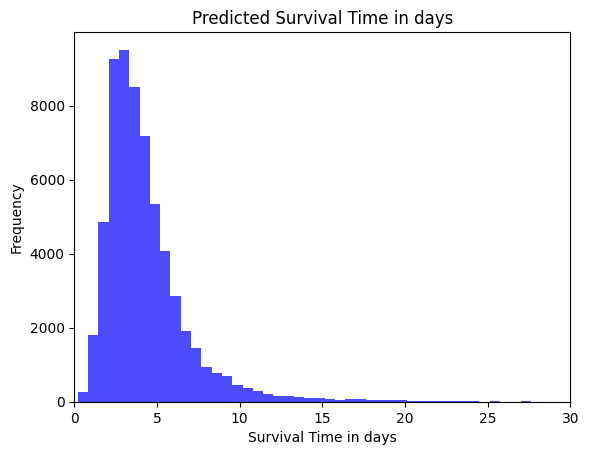

In [209]:
predictions_pd = predictions.select("prediction").toPandas()
plt.hist(predictions_pd["prediction"], bins=200, alpha=0.7, color="blue")
plt.title("Predicted Survival Time in days")
plt.xlabel("Survival Time in days")
plt.ylabel("Frequency")
plt.xlim(0, 30)
plt.show()